In [ ]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from scipy.stats import gaussian_kde

In [ ]:
import numpy as np
snr_values = [-10, -5, 0, 5, 10]

# VAE Baseline

In [ ]:
z_dim = 256
batch_size = 128
device = 'cuda'

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class OriginalVAE(nn.Module):
    def __init__(self, z_dim=256, im_chan=2):
        super(OriginalVAE, self).__init__()
        self.z_dim = z_dim
        self.hidden_dim = int(z_dim // 8)

        # Encoder
        self.encoder = nn.Sequential(
            self.make_encoder_block(im_chan, self.hidden_dim * 2, kernel_size=4, stride=2, padding=1),  # (2, 8, 32) -> (hidden * 2, 4, 16)
            self.make_encoder_block(self.hidden_dim * 2, self.hidden_dim * 4, kernel_size=4, stride=2, padding=1),  # (hidden * 2, 4, 16) -> (hidden * 4, 2, 8)
            self.make_encoder_block(self.hidden_dim * 4, self.hidden_dim * 8, kernel_size=4, stride=2, padding=1),  # (hidden * 4, 2, 8) -> (hidden * 4, 1, 4)
            self.make_encoder_block(self.hidden_dim * 8, self.hidden_dim * 8, kernel_size=4, stride=2, padding=0),  # (hidden * 4, 1, 4) -> (hidden * 4, 1, 1)
        )
        self.fc_mu = nn.Linear(self.hidden_dim * 8, z_dim)
        self.fc_logvar = nn.Linear(self.hidden_dim * 8, z_dim)

        # Decoder
        self.decoder = nn.Sequential(
            self.make_decoder_block(self.hidden_dim * 8, self.hidden_dim * 8, kernel_size=4, stride=2, padding=0),  # (hidden * 4, 1, 1) -> (hidden * 4, 1, 4)
            self.make_decoder_block(self.hidden_dim * 8, self.hidden_dim * 4, kernel_size=4, stride=2, padding=1),  # (hidden * 4, 1, 4) -> (hidden * 4, 2, 8)
            self.make_decoder_block(self.hidden_dim * 4, self.hidden_dim * 2, kernel_size=4, stride=2, padding=1),  # (hidden * 4, 2, 8) -> (hidden * 2, 4, 16)
            self.make_decoder_block(self.hidden_dim * 2, im_chan, kernel_size=4, stride=2, padding=1, final_layer=True),  # (hidden * 2, 4, 16) -> (2, 8, 32)
        )

    def make_encoder_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def make_decoder_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),  # Output in the range [-1, 1]
            )

    def encode(self, x):
        output_encoder = self.encoder(x)
        output_encoder = output_encoder.view(output_encoder.size(0), -1)
        return self.fc_mu(output_encoder), self.fc_logvar(output_encoder), output_encoder

    def reparameterize(self, mu, logvar):

        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)

        z_latent = mu + eps * std

        return z_latent

    def decode(self, z):
        h = z.view(z.size(0), -1, 1, 1)
        return self.decoder(h)

    def forward(self, x, *args):
        mu, logvar, output_encoder = self.encode(x)

        z = self.reparameterize(mu, logvar)

        return self.decode(z), mu, logvar, (z, output_encoder)


# VAE Proposed

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, z_dim=256, im_chan=2, mu_h=None, std_h=None):
        super(VAE, self).__init__()
        self.z_dim = z_dim
        self.hidden_dim = int(z_dim // 8)
        self.mu_h = mu_h
        self.std_h = std_h

        # Encoder
        self.encoder = nn.Sequential(
            self.make_encoder_block(im_chan, self.hidden_dim * 2, kernel_size=4, stride=2, padding=1),  # (2, 8, 32) -> (hidden * 2, 4, 16)
            self.make_encoder_block(self.hidden_dim * 2, self.hidden_dim * 4, kernel_size=4, stride=2, padding=1),  # (hidden * 2, 4, 16) -> (hidden * 4, 2, 8)
            self.make_encoder_block(self.hidden_dim * 4, self.hidden_dim * 8, kernel_size=4, stride=2, padding=1),  # (hidden * 4, 2, 8) -> (hidden * 4, 1, 4)
            self.make_encoder_block(self.hidden_dim * 8, self.hidden_dim * 16, kernel_size=4, stride=2, padding=1),  # (hidden * 4, 2, 8) -> (hidden * 4, 1, 4)
        )

        # Decoder
        self.decoder = nn.Sequential(
            self.make_decoder_block(self.hidden_dim * 16, self.hidden_dim * 8, kernel_size=4, stride=2, padding=1),
            self.make_decoder_block(self.hidden_dim * 8, self.hidden_dim * 4, kernel_size=4, stride=2, padding=1),  # (hidden * 4, 1, 4) -> (hidden * 4, 2, 8)
            self.make_decoder_block(self.hidden_dim * 4, self.hidden_dim * 2, kernel_size=4, stride=2, padding=1),  # (hidden * 4, 2, 8) -> (hidden * 2, 4, 16)
            self.make_decoder_block(self.hidden_dim * 2, im_chan, kernel_size=4, stride=2, padding=1, final_layer=True),  # (hidden * 2, 4, 16) -> (2, 8, 32)
        )

    def make_encoder_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        return nn.Sequential(
            nn.Conv2d(input_channels, output_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(output_channels),
            nn.LeakyReLU(0.2, inplace=True),
        )

    def make_decoder_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),  # Output in the range [-1, 1]
            )

    def encode(self, x):
        output_encoder = self.encoder(x)
        output_encoder = output_encoder.view(output_encoder.size(0), -1)
        return output_encoder

    def reparameterize(self, output_encoder):
        if isinstance(self.mu_h, torch.Tensor) and isinstance(self.mu_h, torch.Tensor):
            z_latent = self.mu_h + output_encoder * self.std_h
        else:
            z_latent = torch.randn(output_encoder.shape).cuda()

        return z_latent


    def decode(self, z):
        h = z.view(z.size(0), -1, 2, 2)
        return self.decoder(h)

    def forward(self, x, *args):
        output_encoder = self.encode(x)

        z = self.reparameterize(output_encoder)

        return self.decode(z), z, z, (z, output_encoder)


# Generator of GAN


In [ ]:
import torch
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self, z_dim=100, im_chan=2, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.hidden_dim = hidden_dim

        self.transform = nn.Sequential(
            nn.Linear(z_dim, hidden_dim * 4 * 4),
            nn.ReLU(),
        )

        self.gen = nn.Sequential(
            self.make_gen_block(hidden_dim, hidden_dim // 2, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim // 2, hidden_dim // 4, kernel_size=4, stride=2, padding=1),
            self.make_gen_block(hidden_dim // 4, im_chan, kernel_size=4, stride=2, padding=1, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=4, stride=2, padding=1, final_layer=False):
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride, padding),
                nn.Tanh(),
            )

    def forward(self, noise):
        x = self.transform(noise)
        x = x.view(len(x), self.hidden_dim, 4, 4)
        return self.gen(x)

# Dataloader

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
import numpy as np

class ChannelsData(torch.utils.data.Dataset):
    def __init__(
        self, channels_res: np.ndarray, y_res: np.ndarray, type_data: str = "train"
    ):
        self.len_dataset = channels_res.shape[0]

        self.transform_channel = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.transform_y_signal = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        ratio = 4/5
        if type_data == "train":
            self.channels_res = channels_res[: int(self.len_dataset * ratio)]
            self.y_res = y_res[: int(self.len_dataset * ratio)]
        elif type_data == "eval":
            self.channels_res = channels_res[int(self.len_dataset * ratio) :]
            self.y_res = y_res[int(self.len_dataset * ratio) :]
            self.channels_res = self.channels_res[: int(len(self.channels_res) / 2)]
            self.y_res = self.y_res[: int(len(self.y_res) / 2)]
        else:
            self.channels_res = channels_res[int(self.len_dataset * ratio) :]
            self.y_res = y_res[int(self.len_dataset * ratio) :]
            self.channels_res = self.channels_res[int(len(self.channels_res) / 2) :]
            self.y_res = self.y_res[int(len(self.y_res) / 2) :]


    def preprocess_response(self, y_res):
        normalized_y_res = np.zeros_like(y_res)
        for i in range(len(y_res)):
            y_res_i = y_res[i]
            y_res_i = (y_res_i - y_res_i.min()) / (y_res_i.max() - y_res_i.min())
            y_res_i = 2 * y_res_i - 1
            normalized_y_res[i] = y_res_i


        normalized_y_res = normalized_y_res.reshape(32, 32, 2).transpose(1,0,2)
        return normalized_y_res

    def preprocess_chanel(self, channel_res):
        normalized_channel_res = np.zeros_like(channel_res)
        for i in range(len(channel_res)):
            channel_res_i = channel_res[i]
            channel_res_i = (channel_res_i - channel_res_i.min()) / (channel_res_i.max() - channel_res_i.min())
            channel_res_i = 2 * channel_res_i - 1
            normalized_channel_res[i] = channel_res_i

        normalized_channel_res = normalized_channel_res.reshape(32, 32, 2).transpose(1,0,2)
        return normalized_channel_res



    def __getitem__(self, item):
        channel_res = self.channels_res[item]
        y_res = self.y_res[item]

        channel_res = self.preprocess_chanel(channel_res)
        y_res = self.preprocess_response(y_res)

        item_channel_res = torch.FloatTensor(channel_res).permute(2, 0, 1)
        item_y_res = torch.FloatTensor(y_res).permute(2, 0, 1)

        return item_channel_res, item_y_res

    def __len__(self):
        return len(self.channels_res)


class ChannelDataloader:
    def __init__(
        self,
        channels_res: np.ndarray,
        y_res: np.ndarray,
        batch_size: int = 64,
        pin_memory: bool = False,
        num_worker: int = 1,
    ):
        self.channels_res = channels_res
        self.y_res = y_res
        self.batch_size = batch_size
        self.pin_memory = pin_memory
        self.num_worker = num_worker

    def train_dataloader(self):
        return DataLoader(
            ChannelsData(
                channels_res=self.channels_res,
                y_res=self.y_res,
                type_data="train",
            ),
            batch_size=self.batch_size,
            pin_memory=self.pin_memory,
            shuffle=True,
            num_workers=self.num_worker,
        )

    def test_dataloader(self):
        return DataLoader(
            ChannelsData(
                channels_res=self.channels_res,
                y_res=self.y_res,
                type_data="test",
            ),
            batch_size=self.batch_size,
            pin_memory=self.pin_memory,
            num_workers=self.num_worker,
            shuffle=False,
        )

    def eval_dataloader(self):
        return DataLoader(
            ChannelsData(
                channels_res=self.channels_res,
                y_res=self.y_res,
                type_data="eval",
            ),
            batch_size=1,
            pin_memory=self.pin_memory,
            num_workers=self.num_worker,
            shuffle=True,
        )


In [ ]:
import gdown
import pickle

def download_and_load_pkl(url, output='output.pkl'):
    # Download the pickle file from Google Drive
    gdown.download(url, output, quiet=False)

    # Load the pickle file
    with open(output, 'rb') as f:
        data = pickle.load(f)

    return data

In [ ]:
# channel sionna, pilot sionna 20000 samples with the same topology
channels = download_and_load_pkl('https://drive.google.com/uc?export=download&id=1OwPoI-pQjuNvDmxhGHkBAweRnR73zwcv', output='channels_res.pkl')
responses = download_and_load_pkl('https://drive.google.com/uc?export=download&id=1lMpM8LJldgIDlXwqaPyg_YFte_bIs80x', output='y_res.pkl')
transmits = download_and_load_pkl('https://drive.google.com/uc?export=download&id=17PN692_smNKzVTqGj0-Gdz-jatCsV9Un', output='rg_input.pkl')
transmits = np.tile(transmits[0], (20000, 1, 1, 1, 1))

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1OwPoI-pQjuNvDmxhGHkBAweRnR73zwcv
From (redirected): https://drive.google.com/uc?export=download&id=1OwPoI-pQjuNvDmxhGHkBAweRnR73zwcv&confirm=t&uuid=fbcb3f74-a089-4848-a1cf-a4d2ff053cbf
To: /content/channels_res.pkl
100%|██████████| 328M/328M [00:03<00:00, 91.2MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=1lMpM8LJldgIDlXwqaPyg_YFte_bIs80x
From (redirected): https://drive.google.com/uc?export=download&id=1lMpM8LJldgIDlXwqaPyg_YFte_bIs80x&confirm=t&uuid=0a908e17-5c79-4789-9c47-1d1d03c058ad
To: /content/y_res.pkl
100%|██████████| 328M/328M [00:03<00:00, 102MB/s]
Downloading...
From (original): https://drive.google.com/uc?export=download&id=17PN692_smNKzVTqGj0-Gdz-jatCsV9Un
From (redirected): https://drive.google.com/uc?export=download&id=17PN692_smNKzVTqGj0-Gdz-jatCsV9Un&confirm=t&uuid=8022be09-ba2e-4580-adfb-2f1f011a4260
To: /content/rg_input.pkl
100%|██████████| 164M/164

In [ ]:
print(responses.shape, channels.shape, transmits.shape)

(20000, 4, 8, 32, 2) (20000, 4, 8, 32, 2) (20000, 4, 8, 32, 2)


In [ ]:
def current_noise(signal, snr):
    snr = 10**(snr/10)

    # signal_power = np.abs(np.mean(signal**2))
    signal_power = 0.01

    noise_power = signal_power / snr

    noise = np.sqrt(noise_power) * (np.random.normal(size=signal.shape) + 1j*np.random.normal(size=signal.shape)) / np.sqrt(2)

    return noise

def generate_responses(current_channels, current_transmits, number_of_sample, snr):
    complex_channels = np.zeros((number_of_sample, *current_channels.shape[1:-1])).astype(np.complex64)
    complex_channels.real = current_channels[..., 0]
    complex_channels.imag = current_channels[..., 1]


    complex_transmits = np.zeros((number_of_sample, *current_transmits.shape[1:-1])).astype(np.complex64)
    complex_transmits.real = current_transmits[..., 0]
    complex_transmits.imag = current_transmits[..., 1]

    complex_responses = np.zeros((number_of_sample, *responses.shape[1:-1])).astype(np.complex64)
    new_responses = np.zeros((number_of_sample, *responses.shape[1:]))

    for i in range(number_of_sample):
        complex_responses[i] = complex_channels[i] * complex_transmits[i]
        complex_responses[i] += current_noise(complex_responses[i], snr)

        new_responses[i, ..., 0] = complex_responses[i].real
        new_responses[i, ..., 1] = complex_responses[i].imag

    return new_responses



In [ ]:
dataloader = ChannelDataloader(y_res=responses, channels_res=channels)
test_dataset = dataloader.test_dataloader()
train_dataset = dataloader.train_dataloader()

In [ ]:
# Compute the mean and std across the first dimension (axis=0)
MU_H = train_dataset.dataset.channels_res.mean(axis=0).reshape(-1)  # Shape: (2*8*32,)
STD_H = train_dataset.dataset.channels_res.std(axis=0).reshape(-1)  # Shape: (2*8*32,)

MU_H = torch.from_numpy(MU_H).float().to(device)
STD_H = torch.from_numpy(STD_H).float().to(device)

# VAE Test set

In [ ]:
all_nmse_scores = {}

In [ ]:
def nmse_func(pred, target):
    """
    Compute the Normalized Mean Squared Error (NMSE) between two tensors.

    Args:
        pred (torch.Tensor): Predicted tensor.
        target (torch.Tensor): Ground truth tensor (target).

    Returns:
        float: The NMSE value.
    """
    # Compute the Mean Squared Error (MSE)
    mse = torch.mean((pred - target) ** 2)

    # Compute the norm of the target tensor
    norm = torch.mean(target ** 2)

    # NMSE is the ratio of MSE to the norm of the target
    nmse_value = mse / norm

    return nmse_value.item()

In [ ]:
def nmse_from_vae(snr):
    current_channels = test_dataset.dataset.channels_res
    current_responses = generate_responses(current_channels, transmits[:current_channels.shape[0]], current_channels.shape[0], snr=snr)

    test_dataset.dataset.y_res = current_responses

    nmse_scores = []
    for i, (channel, response) in enumerate(test_dataset):
        chanel = channel.to(device)
        response = response.to(device)

        fake_channel, *values = vae(response)
        nmse_score = nmse_func(
                        pred=fake_channel.detach().cpu(),
                        target=channel.detach().cpu(),
                    )
        nmse_scores.append(nmse_score)

    return np.mean(nmse_scores)

## VAE Test sets

In [ ]:
model_path = "/content/checkpoint/channel_est_based_vae_multi_antenna/g_model.pt"
vae = OriginalVAE(z_dim=z_dim).to(device)
checkpoint = torch.load(model_path, map_location=device)
vae.load_state_dict(checkpoint["state_dict"])
vae.eval()

total_mnse_scores = []
for snr in tqdm(snr_values):
    nmse_score = nmse_from_vae(snr)
    total_mnse_scores.append(nmse_score)

all_nmse_scores["VAE"] = total_mnse_scores
total_mnse_scores

<ipython-input-88-53f09c51c883>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
100%|██████████| 5/5 [00:06<00:00, 

[0.49764217156916857,
 0.4466680074110627,
 0.42626485135406256,
 0.4270288376137614,
 0.4151431070640683]

In [ ]:
model_path = "/content/checkpoint/channel_est_wgan_gp_based_vae_multi_antenna/g_model.pt"
vae = OriginalVAE(z_dim=z_dim).to(device)
checkpoint = torch.load(model_path, map_location=device)
vae.load_state_dict(checkpoint["state_dict"])
vae.eval()

total_mnse_scores = []
for snr in tqdm(snr_values):
    nmse_score = nmse_from_vae(snr)
    total_mnse_scores.append(nmse_score)

all_nmse_scores["VAE + WGAN-GP"] = total_mnse_scores
total_mnse_scores

<ipython-input-89-af00702e6ef3>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
100%|██████████| 5/5 [00:06<00:00, 

[0.5225638495758176,
 0.4564592782407999,
 0.42623212561011314,
 0.4177723564207554,
 0.41602305695414543]

In [ ]:
model_path = "/content/checkpoint/channel_est_wgan_gp_based_vae_skew_multi_antenna/g_model.pt"
vae = OriginalVAE(z_dim=z_dim).to(device)
checkpoint = torch.load(model_path, map_location=device)
vae.load_state_dict(checkpoint["state_dict"])
vae.eval()

total_mnse_scores = []
for snr in tqdm(snr_values):
    nmse_score = nmse_from_vae(snr)
    total_mnse_scores.append(nmse_score)

all_nmse_scores["VAE + WGAN-GP: Skewness Loss"] = total_mnse_scores
total_mnse_scores

<ipython-input-90-cad2c298af76>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
100%|██████████| 5/5 [00:08<00:00, 

[0.49343958124518394,
 0.43537477776408195,
 0.41632295679301023,
 0.41001972183585167,
 0.4024796085432172]

## VAE Proposed Test sets

In [ ]:
model_path = "/content/checkpoint/channel_est_vae_multi_antenna/g_model.pt"
vae = VAE(z_dim=z_dim, mu_h=MU_H, std_h=STD_H).to(device)
checkpoint = torch.load(model_path, map_location=device)
vae.load_state_dict(checkpoint["state_dict"])
vae.eval()

total_mnse_scores = []
for snr in tqdm(snr_values):
    nmse_score = nmse_from_vae(snr)
    total_mnse_scores.append(nmse_score)

all_nmse_scores["VAE Proposed"] = total_mnse_scores
total_mnse_scores

<ipython-input-91-befcddbe4e1a>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
100%|██████████| 5/5 [00:07<00:00, 

[0.08554301876574755,
 0.03434108122019097,
 0.01575270638568327,
 0.01019904256099835,
 0.008717386226635426]

In [ ]:
model_path = "/content/checkpoint/channel_est_wgan_gp_vae_multi_antenna/g_model.pt"
vae = VAE(z_dim=z_dim, mu_h=MU_H, std_h=STD_H).to(device)
checkpoint = torch.load(model_path, map_location=device)
vae.load_state_dict(checkpoint["state_dict"])
vae.eval()

total_mnse_scores = []
for snr in tqdm(snr_values):
    nmse_score = nmse_from_vae(snr)
    total_mnse_scores.append(nmse_score)

all_nmse_scores["VAE Proposed + WGAN-GP"] = total_mnse_scores
total_mnse_scores

<ipython-input-92-e66f69df55f0>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
100%|██████████| 5/5 [00:06<00:00, 

[0.07786329067312181,
 0.031599135778378695,
 0.013976422313135117,
 0.009068473911611363,
 0.007661360592464916]

In [ ]:
model_path = "/content/checkpoint/channel_est_wgan_gp_vae_skew_multi_antenna/g_model.pt"
vae = VAE(z_dim=z_dim, mu_h=MU_H, std_h=STD_H).to(device)
checkpoint = torch.load(model_path, map_location=device)
vae.load_state_dict(checkpoint["state_dict"])
vae.eval()

total_mnse_scores = []
for snr in tqdm(snr_values):
    nmse_score = nmse_from_vae(snr)
    total_mnse_scores.append(nmse_score)

all_nmse_scores["VAE Proposed + WGAN-GP: Skewness Loss"] = total_mnse_scores
total_mnse_scores

<ipython-input-93-a6bb3638a1af>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
100%|██████████| 5/5 [00:07<00:00, 

[0.07152116717770696,
 0.028189316391944885,
 0.012367177900159732,
 0.007060851654387079,
 0.0056619682582095265]

# GAN Test

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data.dataloader import DataLoader
import numpy as np

class ChannelsDataGAN(torch.utils.data.Dataset):
    def __init__(
        self, channels_res: np.ndarray, y_res: np.ndarray, type_data: str = "train"
    ):
        self.len_dataset = channels_res.shape[0]

        self.transform_channel = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        self.transform_y_signal = transforms.Compose(
            [
                transforms.ToTensor(),
            ]
        )
        ratio = 4 / 5
        if type_data == "train":
            self.channels_res = channels_res[: int(self.len_dataset * ratio)]
            self.y_res = y_res[: int(self.len_dataset * ratio)]
        elif type_data == "eval":
            self.channels_res = channels_res[int(self.len_dataset * ratio) :]
            self.y_res = y_res[int(self.len_dataset * ratio) :]
            self.channels_res = self.channels_res[: int(len(self.channels_res) / 2)]
            self.y_res = self.y_res[: int(len(self.y_res) / 2)]
        else:
            self.channels_res = channels_res[int(self.len_dataset * ratio) :]
            self.y_res = y_res[int(self.len_dataset * ratio) :]
            self.channels_res = self.channels_res[int(len(self.channels_res) / 2) :]
            self.y_res = self.y_res[int(len(self.y_res) / 2) :]


    def preprocess_response(self, y_res):

        # y_res = y_res.T.flatten()

        normalized_y_res = np.zeros_like(y_res)
        for i in range(len(y_res)):
            y_res_i = y_res[i]
            y_res_i = (y_res_i - y_res_i.min()) / (y_res_i.max() - y_res_i.min())
            y_res_i = 2 * y_res_i - 1
            normalized_y_res[i] = y_res_i


        normalized_y_res = normalized_y_res.reshape(32, 32, 2).transpose(1,0,2)
        normalized_y_res = normalized_y_res.T.flatten()
        return normalized_y_res

    def preprocess_chanel(self, channel_res):
        # Get the real part of the complex number

        # channel_res = channel_res[:,:,0]

        # channel_res = (channel_res - channel_res.min()) / (channel_res.max() - channel_res.min())
        # channel_res = 2 * channel_res - 1

        normalized_channel_res = np.zeros_like(channel_res)
        for i in range(len(channel_res)):
            channel_res_i = channel_res[i]
            channel_res_i = (channel_res_i - channel_res_i.min()) / (channel_res_i.max() - channel_res_i.min())
            channel_res_i = 2 * channel_res_i - 1
            normalized_channel_res[i] = channel_res_i

        normalized_channel_res = normalized_channel_res.reshape(32, 32, 2).transpose(1,0,2)
        return normalized_channel_res

    def __getitem__(self, item):
        channel_res = self.channels_res[item]
        y_res = self.y_res[item]

        channel_res = self.preprocess_chanel(channel_res)
        y_res = self.preprocess_response(y_res)

        item_channel_res = torch.FloatTensor(channel_res).permute(2, 0, 1)
        item_y_res = torch.FloatTensor(y_res)

        return item_channel_res, item_y_res

    def __len__(self):
        return len(self.channels_res)


class ChannelDataloaderGAN:
    def __init__(
        self,
        channels_res: np.ndarray,
        y_res: np.ndarray,
        batch_size: int = 64,
        pin_memory: bool = False,
        num_worker: int = 1,
    ):
        self.channels_res = channels_res
        self.y_res = y_res
        self.batch_size = batch_size
        self.pin_memory = pin_memory
        self.num_worker = num_worker

    def train_dataloader(self):
        return DataLoader(
            ChannelsDataGAN(
                channels_res=self.channels_res,
                y_res=self.y_res,
                type_data="train",
            ),
            batch_size=self.batch_size,
            pin_memory=self.pin_memory,
            shuffle=True,
            num_workers=self.num_worker,
        )

    def test_dataloader(self):
        return DataLoader(
            ChannelsDataGAN(
                channels_res=self.channels_res,
                y_res=self.y_res,
                type_data="test",
            ),
            batch_size=1,
            pin_memory=self.pin_memory,
            num_workers=self.num_worker,
            shuffle=False,
        )

    def eval_dataloader(self):
        return DataLoader(
            ChannelsDataGAN(
                channels_res=self.channels_res,
                y_res=self.y_res,
                type_data="eval",
            ),
            batch_size=1,
            pin_memory=self.pin_memory,
            num_workers=self.num_worker,
            shuffle=True,
        )

dataloader_gan = ChannelDataloaderGAN(y_res=responses, channels_res=channels)
test_dataset_gan = dataloader_gan.test_dataloader()


def nmse_from_gan(snr):
    current_channels = test_dataset_gan.dataset.channels_res
    current_responses = generate_responses(current_channels, transmits[:current_channels.shape[0]], current_channels.shape[0], snr=snr)

    test_dataset_gan.dataset.y_res = current_responses

    nmse_scores = []
    for i, (channel, response) in enumerate(test_dataset_gan):
        chanel = channel.to(device)
        response = response.to(device)

        fake_channel = generator(response)
        nmse_score = nmse_func(
                        pred=fake_channel.detach().cpu(),
                        target=channel.detach().cpu(),
                    )
        nmse_scores.append(nmse_score)

    return np.mean(nmse_scores)

In [ ]:
model_path = "/content/checkpoint/channel_est_wgan_gp/g_model.pt"
generator = Generator((32 * 32 * 2)).to(device)
checkpoint = torch.load(model_path, map_location=device)
generator.load_state_dict(checkpoint["state_dict"])
generator.eval()

total_mnse_scores = []
for snr in tqdm(snr_values):
    nmse_score = nmse_from_gan(snr)
    total_mnse_scores.append(nmse_score)

all_nmse_scores["WGAN-GP"] = total_mnse_scores
total_mnse_scores

<ipython-input-95-2513f294e398>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
100%|██████████| 5/5 [00:34<00:00, 

[0.9967362646758556,
 0.9951796207129955,
 0.9941799937784672,
 0.9938967012465,
 0.9936059835553169]

# LS + VAE

In [ ]:
def ls_channel(response, transmit, epsilon=1e-10):
    mask = np.abs(transmit) <= epsilon

    estimated_channel = np.zeros_like(response, dtype=complex)

    estimated_channel[~mask] = response[~mask] / transmit[~mask]
    return estimated_channel

def ls_method(current_responses, current_transmits, number_of_sample):
    complex_responses = np.zeros((number_of_sample, *current_responses.shape[1:-1])).astype(np.complex64)
    complex_responses.real = current_responses[..., 0]
    complex_responses.imag = current_responses[..., 1]

    complex_transmits = np.zeros((number_of_sample, *current_transmits.shape[1:-1])).astype(np.complex64)
    complex_transmits.real = current_transmits[..., 0]
    complex_transmits.imag = current_transmits[..., 1]

    estimated_channels = np.zeros((number_of_sample, *channels.shape[1:]))

    for i in range(number_of_sample):
        estimated_channel = ls_channel(complex_responses[i], complex_transmits[i])
        estimated_channels[i, ..., 0] = estimated_channel.real
        estimated_channels[i, ..., 1] = estimated_channel.imag

    return estimated_channels


In [ ]:
# current_channels = test_dataset.dataset.channels_res
# new_response = generate_responses(current_channels[:10], transmits[:10], 10, snr=-30)
# estimated_channels = ls_method(new_response[:10], transmits[:10], 10)

# LS + Interpolation Test set

In [ ]:
import gdown
import pickle
import torch
from sionna.ofdm import ResourceGrid
import numpy as np
import tensorflow as tf
from sionna.ofdm import (
    LMMSEInterpolator,
    LSChannelEstimator,
)
import sionna
from tqdm import tqdm

In [ ]:
num_ofdm_symbols=8
fft_size=32
num_tx=1
number_antennas = 4
cyclic_prefix_length=0
subcarrier_spacing=30e3
carrier_frequency = 3.5e9
pilot_pattern="kronecker"
pilot_ofdm_symbol_indices=[2, 6]

In [ ]:
def get_resource_grid(
    num_ofdm_symbols: int = 14,
    fft_size: int = 612,
    num_tx: int = 1,
    cyclic_prefix_length: int = 0,
    subcarrier_spacing: int = 30e3,
    pilot_pattern: int = "kronecker",
    pilot_ofdm_symbol_indices: list = [2, 11],
):
    rg = ResourceGrid(
        num_ofdm_symbols=num_ofdm_symbols,
        fft_size=fft_size,
        num_tx=num_tx,
        cyclic_prefix_length=cyclic_prefix_length,
        subcarrier_spacing=subcarrier_spacing,
        pilot_pattern=pilot_pattern,
        pilot_ofdm_symbol_indices=pilot_ofdm_symbol_indices,
    )
    return rg

In [ ]:
@tf.function(jit_compile=True)  # Use XLA for speed-up
def estimate_covariance_matrices(num_it):
    current_channels = test_dataset.dataset.channels_res
    h_freq = np.zeros((current_channels.shape[0], number_antennas, num_ofdm_symbols, fft_size), dtype=np.complex64)
    h_freq.real = current_channels[..., 0]
    h_freq.imag = current_channels[..., 1]

    freq_cov_mat = tf.zeros([fft_size, fft_size], tf.complex64)
    time_cov_mat = tf.zeros([num_ofdm_symbols, num_ofdm_symbols], tf.complex64)
    space_cov_mat = tf.zeros([number_antennas, number_antennas], tf.complex64)
    for _ in tf.range(num_it):
        # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
        h_samples = h_freq.reshape(current_channels.shape[0], number_antennas, num_ofdm_symbols, fft_size)
        #################################
        # Estimate frequency covariance
        #################################
        # [batch size, num_rx_ant, fft_size, num_ofdm_symbols]
        h_samples_ = tf.transpose(h_samples, [0, 1, 3, 2])
        # [batch size, num_rx_ant, fft_size, fft_size]
        freq_cov_mat_ = tf.matmul(h_samples_, h_samples_, adjoint_b=True)
        # [fft_size, fft_size]
        freq_cov_mat_ = tf.reduce_mean(freq_cov_mat_, axis=(0, 1))
        # [fft_size, fft_size]
        freq_cov_mat += freq_cov_mat_

        ################################
        # Estimate time covariance
        ################################
        # [batch size, num_rx_ant, num_ofdm_symbols, fft_size]
        time_cov_mat_ = tf.matmul(h_samples, h_samples, adjoint_b=True)
        # [num_ofdm_symbols, num_ofdm_symbols]
        time_cov_mat_ = tf.reduce_mean(time_cov_mat_, axis=(0, 1))
        # [num_ofdm_symbols, num_ofdm_symbols]
        time_cov_mat += time_cov_mat_

        ###############################
        # Estimate spatial covariance
        ###############################
        # [batch size, num_ofdm_symbols, num_rx_ant, fft_size]
        h_samples_ = tf.transpose(h_samples, [0, 2, 1, 3])
        # [batch size, num_ofdm_symbols, num_rx_ant, num_rx_ant]
        space_cov_mat_ = tf.matmul(h_samples_, h_samples_, adjoint_b=True)
        # [num_rx_ant, num_rx_ant]
        space_cov_mat_ = tf.reduce_mean(space_cov_mat_, axis=(0, 1))
        # [num_rx_ant, num_rx_ant]
        space_cov_mat += space_cov_mat_

    freq_cov_mat /= tf.complex(tf.cast(fft_size * num_it, tf.float32), 0.0)
    time_cov_mat /= tf.complex(tf.cast(num_ofdm_symbols * num_it, tf.float32), 0.0)
    space_cov_mat /= tf.complex(tf.cast(number_antennas * num_it, tf.float32), 0.0)

    return freq_cov_mat, time_cov_mat, space_cov_mat

In [ ]:
import numpy as np
import pickle

from tensorflow.keras import Model

from sionna.mimo import StreamManagement
from sionna.utils import QAMSource, compute_ser, BinarySource, sim_ber, ebnodb2no, QAMSource
from sionna.mapping import Mapper
from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEInterpolator, LinearDetector, KBestDetector, EPDetector, MMSEPICDetector
from sionna.channel import GenerateOFDMChannel, OFDMChannel, gen_single_sector_topology
from sionna.channel.tr38901 import UMi, Antenna, PanelArray
from sionna.fec.ldpc import LDPC5GEncoder
from sionna.fec.ldpc import LDPC5GDecoder


def load_topology(filename):
    with open('topology.pkl', 'rb') as f:
      loaded_topology = pickle.load(f)

    # Convert all numpy arrays to TensorFlow tensors
    for key, value in loaded_topology.items():
        loaded_topology[key] = tf.convert_to_tensor(value)

    return loaded_topology


# The user terminals (UTs) are equipped with a single antenna
# with vertial polarization.
UT_ANTENNA = Antenna(polarization='single',
                     polarization_type='V',
                     antenna_pattern='omni', # Omnidirectional antenna pattern
                     carrier_frequency=carrier_frequency)

# The base station is equipped with an antenna
# array of 8 cross-polarized antennas,
# resulting in a total of 16 antenna elements.
BS_ARRAY = PanelArray(num_rows_per_panel=1,
                        num_cols_per_panel=4,
                        polarization='single',
                        polarization_type='V',
                        antenna_pattern='38.901', # 3GPP 38.901 antenna pattern
                        carrier_frequency=carrier_frequency)

# 3GPP UMi channel model is considered
CHANNEL_MODEL = UMi(carrier_frequency=carrier_frequency,
                    o2i_model='low',
                    ut_array=UT_ANTENNA,
                    bs_array=BS_ARRAY,
                    direction='uplink',
                    enable_shadow_fading=False,
                    enable_pathloss=True)


# sionna.Config.xla_compat = True # Enable Sionna's support of XLA
FREQ_COV_MAT, TIME_COV_MAT, SPACE_COV_MAT = estimate_covariance_matrices(100)
# sionna.Config.xla_compat = False # Disable Sionna's support of XLA



class MIMOOFDMLink(Model):

    def __init__(self, int_method, lmmse_order=None, **kwargs):
        super().__init__(kwargs)

        assert int_method in ('nn', 'lin', 'lmmse')


        # Configure the resource grid
        rg = ResourceGrid(num_ofdm_symbols=num_ofdm_symbols,
                          fft_size=fft_size,
                          subcarrier_spacing=subcarrier_spacing,
                          num_tx=1,
                          pilot_pattern="kronecker",
                          pilot_ofdm_symbol_indices=[2,6])
        self.rg = rg


        # Stream management
        # Only a sinlge UT is considered for channel estimation
        sm = StreamManagement([[1]], 1)

        ##################################
        # Transmitter
        ##################################

        self.qam_source = QAMSource(num_bits_per_symbol=2) # Modulation order does not impact the channel estimation. Set to QPSK
        self.rg_mapper = ResourceGridMapper(rg)

        self.binary_source = BinarySource()
        self.mapper = Mapper(constellation_type="qam", num_bits_per_symbol=2)

        ##################################
        # Channel
        ##################################

        self.channel = OFDMChannel(CHANNEL_MODEL, rg, return_channel=True)

        ###################################
        # Receiver
        ###################################

        # Channel estimation
        freq_cov_mat = tf.constant(FREQ_COV_MAT, tf.complex64)
        time_cov_mat = tf.constant(TIME_COV_MAT, tf.complex64)
        space_cov_mat = tf.constant(SPACE_COV_MAT, tf.complex64)
        if int_method == 'nn':
            self.channel_estimator = LSChannelEstimator(rg, interpolation_type='nn')
        elif int_method == 'lin':
            self.channel_estimator = LSChannelEstimator(rg, interpolation_type='lin')
        elif int_method == 'lmmse':
            lmmse_int_freq_first = LMMSEInterpolator(rg.pilot_pattern, time_cov_mat, freq_cov_mat, space_cov_mat, order=lmmse_order)
            self.channel_estimator = LSChannelEstimator(rg, interpolator=lmmse_int_freq_first)

    @tf.function
    def call(self, batch_size, snr_db, y_rg=None):


        ##################################
        # Transmitter
        ##################################

        x = self.qam_source([batch_size, 1, 1, self.rg.num_data_symbols])
        x_rg = self.rg_mapper(x)


        ##################################
        # Channel
        ##################################

        no = tf.pow(10.0, -snr_db/10.0)
        topology = download_and_load_pkl(
            "https://drive.google.com/uc?export=download&id=1wqYhtbfYRg3oqrRowbS3VlyUwEy3RC6S",
            output="topology.pkl",
        )
        values_topology = list(load_topology(topology).values())
        CHANNEL_MODEL.set_topology(*values_topology)

        y_rg, h_freq = self.channel((x_rg, no))
        ###################################
        # Channel estimation
        ###################################



        h_hat,_ = self.channel_estimator((y_rg,no))

        ###################################
        # MSE
        ###################################

        mse = tf.reduce_mean(tf.square(tf.abs(h_freq-h_hat)))

        return mse

In [ ]:
from tqdm import tqdm
def evaluate_mse(model, snr_dbs, batch_size, num_it):

    # Casting model inputs to TensorFlow types to avoid
    # re-building of the graph
    snr_dbs = tf.cast(snr_dbs, tf.float32)
    batch_size = tf.cast(batch_size, tf.int32)

    mses = []
    for snr_db in tqdm(snr_dbs):

        mse_ = 0.0

        for _ in range(num_it):
            mse_ += model(batch_size, snr_db).numpy()
        # Averaging over the number of iterations
        mse_ /= float(num_it)
        mses.append(mse_)

    return mses

In [ ]:
ORDERS = ['s-t-f', # Space - time - frequency
          't-f-s', # Time - frequency - space
          't-f'   # Time - frequency (no spatial smoothing)
          ]

MSES = {}

# Nearest-neighbor interpolation
e2e = MIMOOFDMLink("nn")
all_nmse_scores["LS + Nearest neighbour"] = evaluate_mse(e2e, snr_values, batch_size, 100)

# Linear interpolation
e2e = MIMOOFDMLink("lin")
all_nmse_scores["LS + Linear"] = evaluate_mse(e2e, snr_values, batch_size, 100)

# LMMSE
for order in ORDERS:
    e2e = MIMOOFDMLink("lmmse", order)
    all_nmse_scores[f"LS + LMMSE: {order}"] = evaluate_mse(e2e, snr_values, batch_size, 100)


  0%|          | 0/5 [00:00<?, ?it/s]Downloading...
From: https://drive.google.com/uc?export=download&id=1wqYhtbfYRg3oqrRowbS3VlyUwEy3RC6S
To: /content/topology.pkl

  0%|          | 0/5 [00:00<?, ?it/s]Downloading...
From: https://drive.google.com/uc?export=download&id=1wqYhtbfYRg3oqrRowbS3VlyUwEy3RC6S
To: /content/topology.pkl

  0%|          | 0/5 [00:00<?, ?it/s]Downloading...
From: https://drive.google.com/uc?export=download&id=1wqYhtbfYRg3oqrRowbS3VlyUwEy3RC6S
To: /content/topology.pkl

  0%|          | 0/5 [00:00<?, ?it/s]Downloading...
From: https://drive.google.com/uc?export=download&id=1wqYhtbfYRg3oqrRowbS3VlyUwEy3RC6S
To: /content/topology.pkl

  0%|          | 0/5 [00:00<?, ?it/s]Downloading...
From: https://drive.google.com/uc?export=download&id=1wqYhtbfYRg3oqrRowbS3VlyUwEy3RC6S
To: /content/topology.pkl

100%|██████████| 5/5 [02:50<00:00, 34.03s/it]


In [ ]:
from pprint import pprint
pprint(all_nmse_scores)

{'LS + LMMSE: s-t-f': [0.04966490473598242,
                       0.03509670797735453,
                       0.02043961813673377,
                       0.01030463053844869,
                       0.004624484134837985],
 'LS + LMMSE: t-f': [0.05551251266151667,
                     0.04200358908623457,
                     0.02293750138953328,
                     0.01087481303140521,
                     0.004693700838834048],
 'LS + LMMSE: t-f-s': [0.21118827000260354,
                       0.0779270987212658,
                       0.03041905486956239,
                       0.01219491183757782,
                       0.004956610524095595],
 'LS + Linear': [11.853997373580933,
                 3.7552960968017577,
                 1.1876570868492127,
                 0.37529272466897967,
                 0.11886079214513302],
 'LS + Nearest neighbour': [9.997300090789794,
                            3.1623695302009582,
                            1.0000373929739,
                 

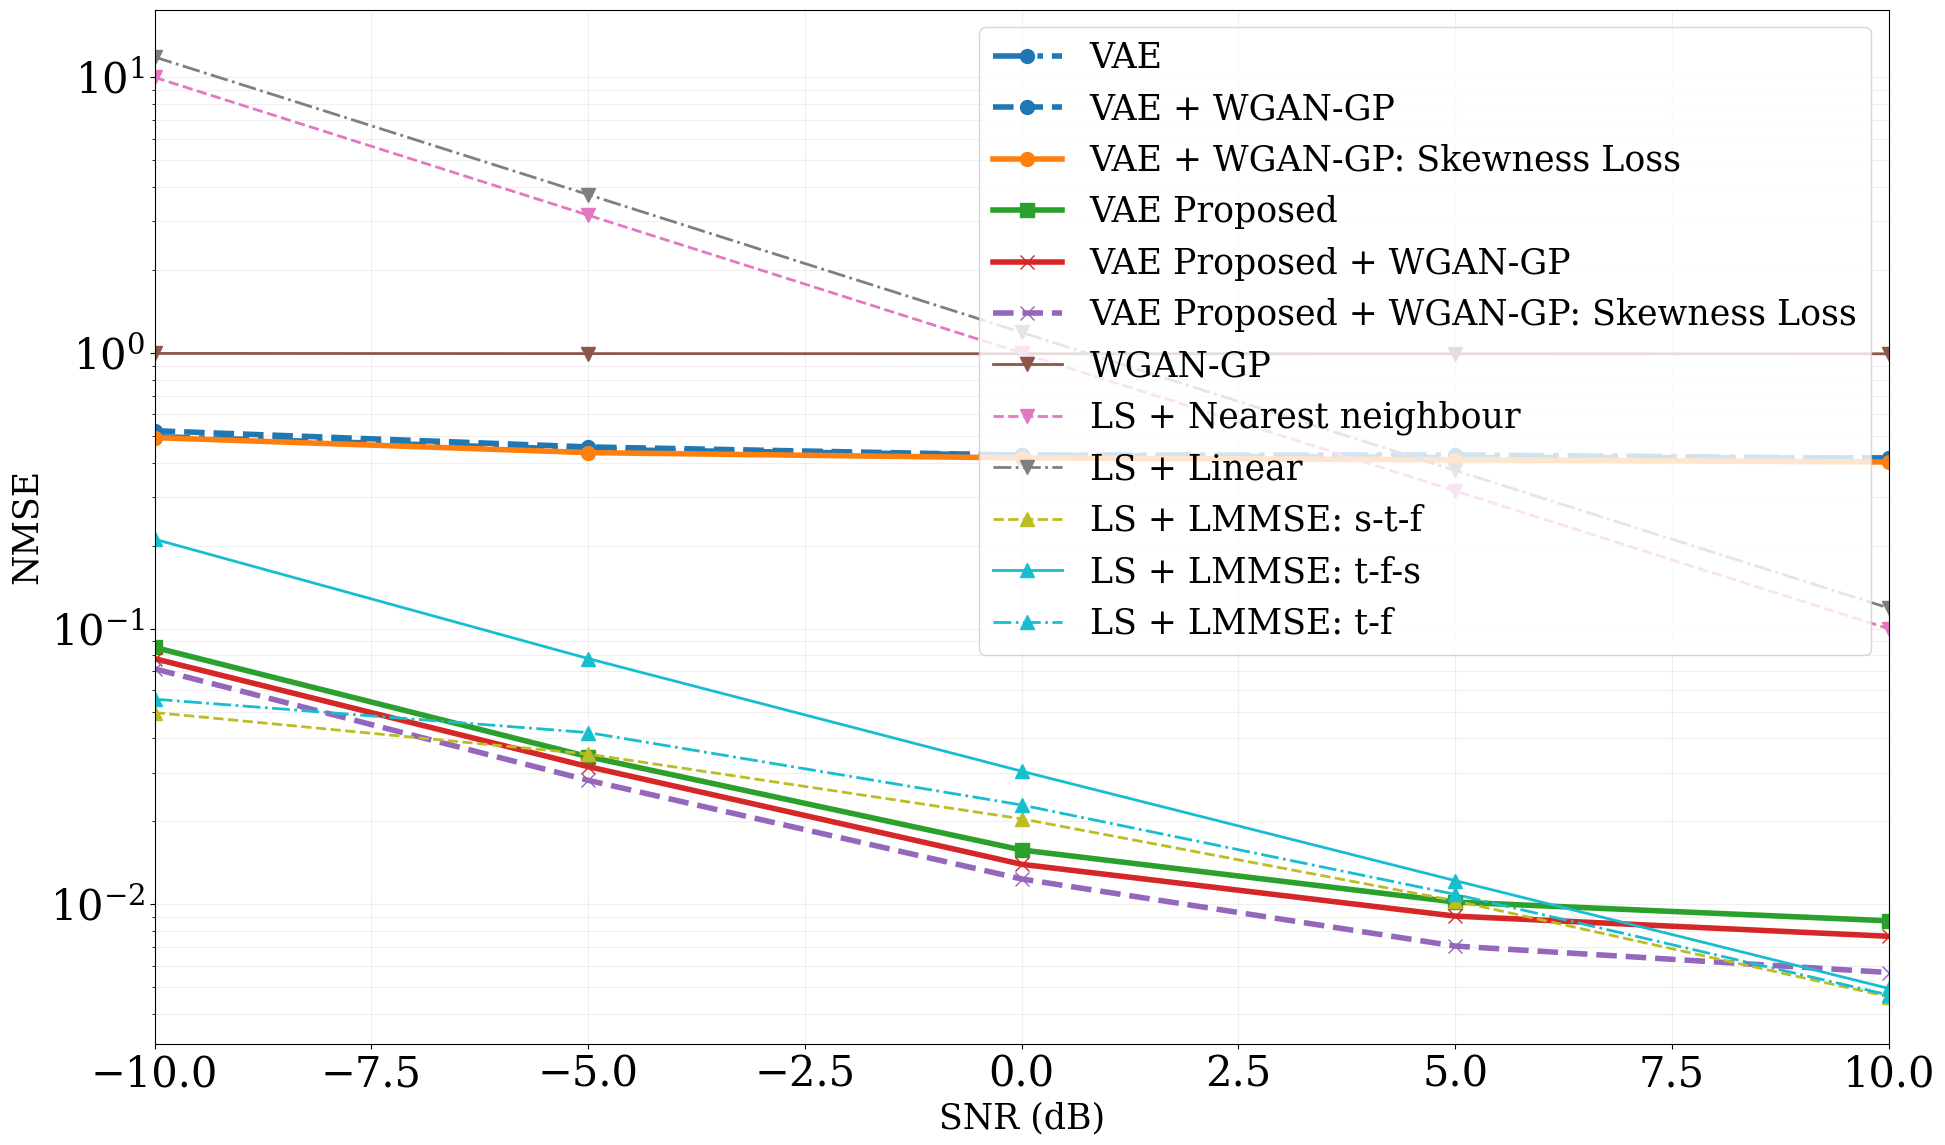

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 12))
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 25
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams["legend.fontsize"] = 25



line_styles = ["-.o", "--o", "-o", "-s", "-x", "--x", "-v", "--v", "-.v", "--^", "-^", "-.^"]
colors = plt.cm.tab10(np.linspace(0, 1, len(all_nmse_scores)))

# Plot all lines except the lowest one first
for (model, nmse_values), line_style, color in zip(
    all_nmse_scores.items(), line_styles, colors
):
    if "VAE" in model:
      plt.semilogy(
          snr_values,
          nmse_values,
          line_style,
          label=model,
          color=color,
          linewidth=4,
          markersize=10,
      )
    else:
      plt.semilogy(
          snr_values,
          nmse_values,
          line_style,
          label=model,
          color=color,
          linewidth=2,
          markersize=10,
      )

plt.xlabel("SNR (dB)")
plt.ylabel("NMSE")
plt.legend(loc="upper right")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xlim(min(snr_values), max(snr_values))

plt.tight_layout()
plt.savefig("nmse_snr_topology_6_highlighted.png")
plt.show()

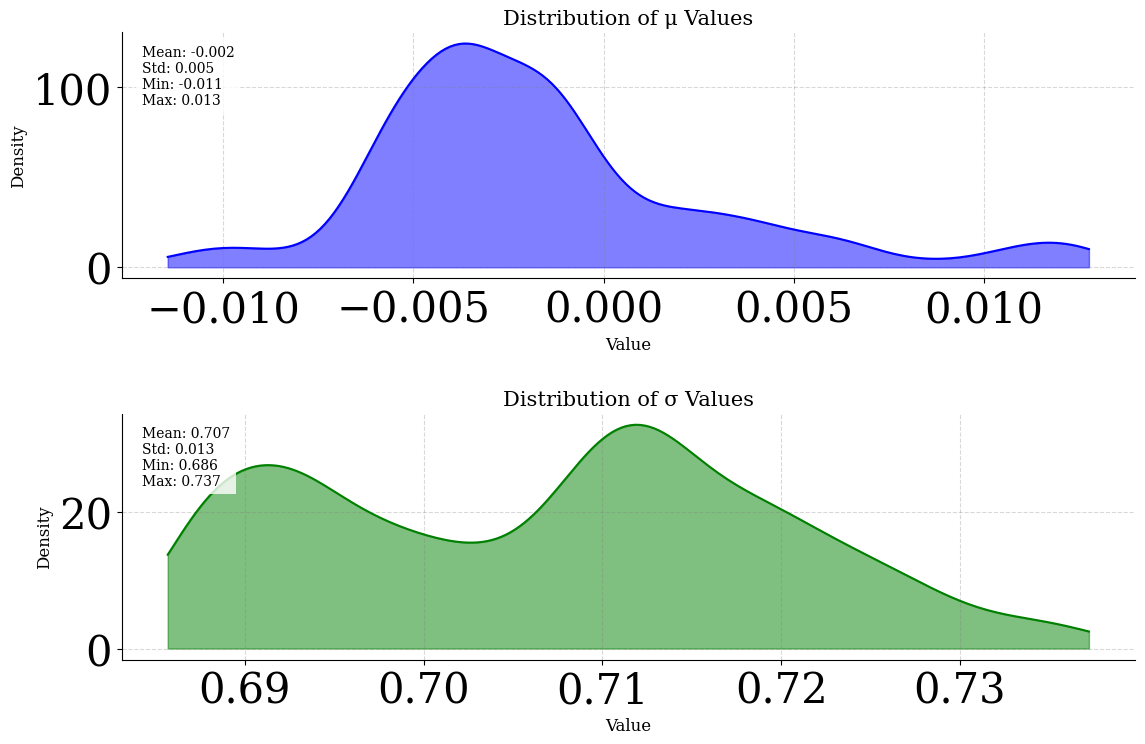

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import torch

def plot_distribution_parameters_kde(mu_total, sigma_total):
    """
    Create KDE plots of mu and sigma distributions from GPU tensors with custom styling.

    Parameters:
    mu_total: torch.Tensor on GPU of shape (1280,) - means
    sigma_total: torch.Tensor on GPU of shape (1280,) - standard deviations
    """
    # Convert GPU tensors to numpy arrays
    mu_np = mu_total.detach().cpu().numpy()
    sigma_np = sigma_total.detach().cpu().numpy()

    # Create figure with two subplots
    fig, axes = plt.subplots(2, 1, figsize=(12, 8))

    # Data, titles, and colors for each plot
    data = [mu_np, sigma_np]
    titles = ['Distribution of μ Values', 'Distribution of σ Values']
    colors = ['blue', 'green']

    # Create plots
    for ax, d, title, color in zip(axes, data, titles, colors):
        # Calculate KDE
        kde = gaussian_kde(d)
        x_range = np.linspace(d.min(), d.max(), 200)

        # Plot KDE
        ax.plot(x_range, kde(x_range), color=color)
        ax.fill_between(x_range, kde(x_range), alpha=0.5, color=color)

        # Set title and labels
        ax.set_title(title, color='black', fontsize=15)
        ax.set_xlabel("Value", color='black', fontsize=12)
        ax.set_ylabel("Density", color='black', fontsize=12)

        # Customize grid and spines
        ax.grid(color='gray', linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.tick_params(colors='black')

        # Add statistics text
        stats_text = (f'Mean: {d.mean():.3f}\nStd: {d.std():.3f}\n'
                     f'Min: {d.min():.3f}\nMax: {d.max():.3f}')

        ax.text(0.02, 0.95, stats_text,
               transform=ax.transAxes,
               bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'),
               verticalalignment='top',
               fontsize=10)

    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming you have GPU tensors:
# mu_total = torch.randn(1280).cuda()
# sigma_total = torch.abs(torch.randn(1280)).cuda()

plot_distribution_parameters_kde(MU_H, STD_H)

In [ ]:
def plot_vae_results(labels, reals, fakes, mses, num_samples=8):
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 4*num_samples))
    fig.suptitle("VAE Results: Label, Real, and Fake", fontsize=16)

    for i in range(num_samples):
        for j, (title, img) in enumerate(zip(['Label', 'Real', 'Fake'], [labels[i], reals[i], fakes[i]])):
            axes[i, j].imshow(img.squeeze().detach().cpu().numpy(), cmap='viridis')
            axes[i, j].set_title(f"{title} (Sample {i+1})")
            axes[i, j].axis('off')

        # Add MSE text to the right of the fake image
        axes[i, 2].text(1.05, 0.5, f'MSE: {mses[i]:.4f}',
                        transform=axes[i, 2].transAxes,
                        verticalalignment='center')

def plot_vae_in_out(input_tensor, output, z, encoder_output, true_output):
    # Convert to numpy arrays
    encoder_input_np = input_tensor.detach().cpu().numpy().flatten()
    encoder_output_np = encoder_output.detach().cpu().numpy().flatten()
    decoder_input_np = z.detach().cpu().numpy().flatten()
    decoder_output_np = output.detach().cpu().numpy().flatten()
    true_output_np = true_output.detach().cpu().numpy().flatten()
    mu_h_np = MU_H.detach().cpu().numpy().flatten()

    # Create a figure with five subplots in a single row
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(24, 4))
    # fig.patch.set_facecolor('#2F2F2F')

    # Define the data and labels for each subplot
    data = [encoder_input_np, encoder_output_np, decoder_input_np, decoder_output_np, true_output_np, mu_h_np]
    titles = ["Encoder Input", "Encoder Output", "Decoder Input", "Decoder Output", "True Output", "Distribution of Mean"]
    shapes = [input_tensor.shape, encoder_output.shape, z.shape, output.shape, true_output.shape, MU_H.shape]
    colors = ['cyan', 'magenta', 'brown', 'green', 'red', "blue"]
    axes = [ax1, ax2, ax3, ax4, ax5, ax6]

    for ax, d, title, shape, color in zip(axes, data, titles, shapes, colors):
        kde = gaussian_kde(d)
        x_range = np.linspace(d.min(), d.max(), 200)

        ax.plot(x_range, kde(x_range), color=color)
        ax.fill_between(x_range, kde(x_range), alpha=0.5, color=color)

        # ax.set_title(f"{title}", color='black', fontsize=20)
        ax.set_xlabel("Value", color='black', fontsize=15)
        ax.set_ylabel("Density", color='black', fontsize=15)

        ax.grid(color='gray', linestyle='--', alpha=0.3)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_color('black')
        ax.spines['left'].set_color('black')
        ax.tick_params(colors='black')


    plt.tight_layout()
    plt.savefig("fig_distribution.png", format="png", dpi=500)
    plt.show()
    plt.close()


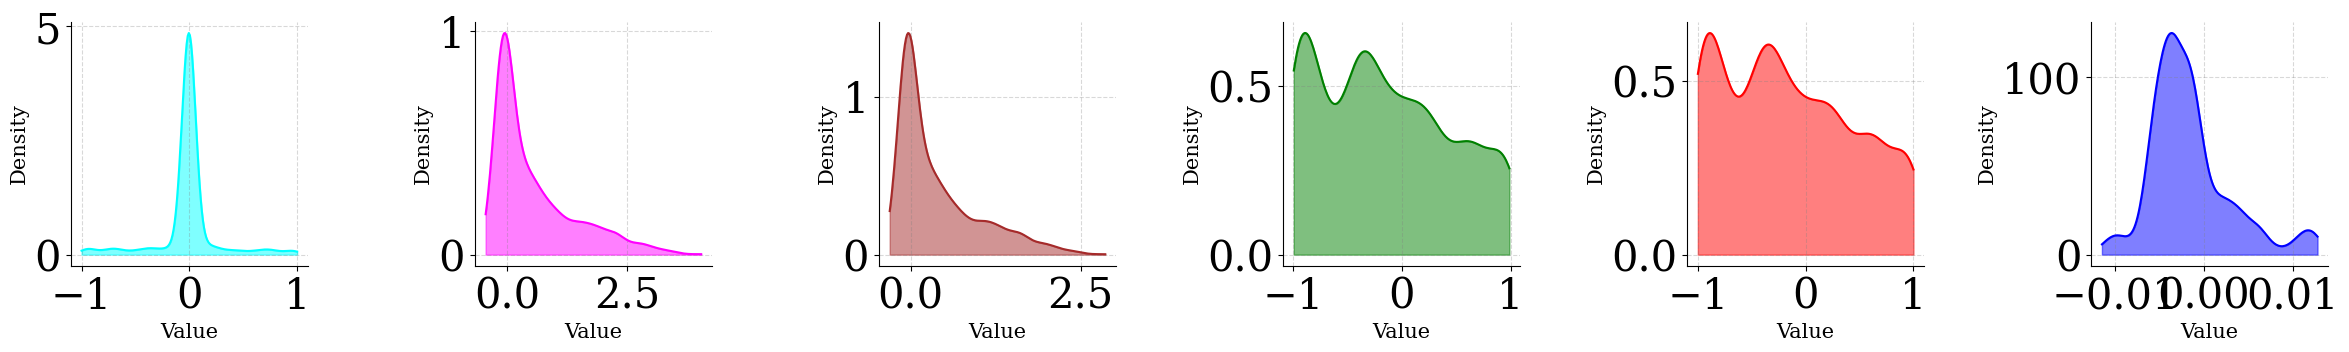

0.005008414731491939


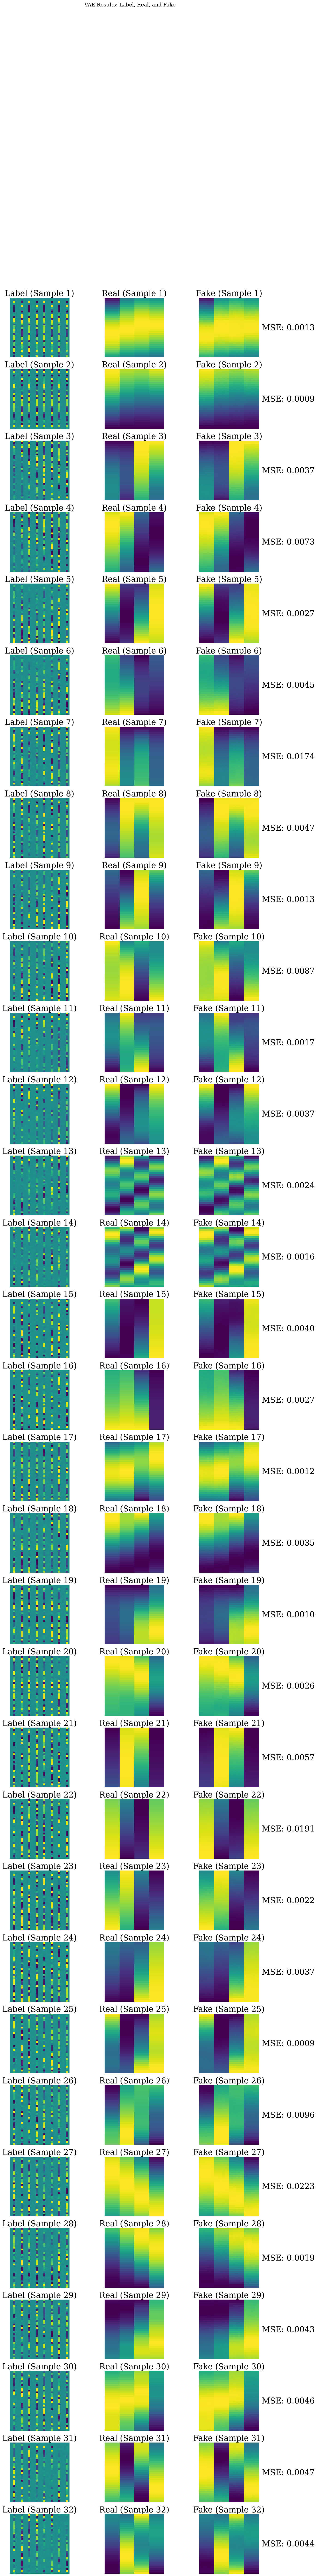

In [ ]:
num_samples = 32
labels, reals, fakes, nmses = [], [], [], []

dataloader = ChannelDataloader(
    y_res=responses, channels_res=channels, batch_size=1
)
test_dataset = dataloader.test_dataloader()

for i, (real, label) in enumerate(test_dataset):
    real = real.to(device)
    label = label.to(device)
    fake, *values = vae(label)
    _, _, (input_decoder, output_encoder) = values

    if i >= num_samples:
        break

    labels.append(label[0])
    reals.append(real[0])
    fakes.append(fake[0])
    nmses.append(nmse_func(fake, real))

    if i == 24:
      plot_vae_in_out(label, fake, input_decoder, output_encoder, real)




# Convert lists to tensors
labels = torch.cat(labels, dim=0)
reals = torch.cat(reals, dim=0)
fakes = torch.cat(fakes, dim=0)

print(np.mean(nmses))
plot_vae_results(labels, reals, fakes, nmses, num_samples)



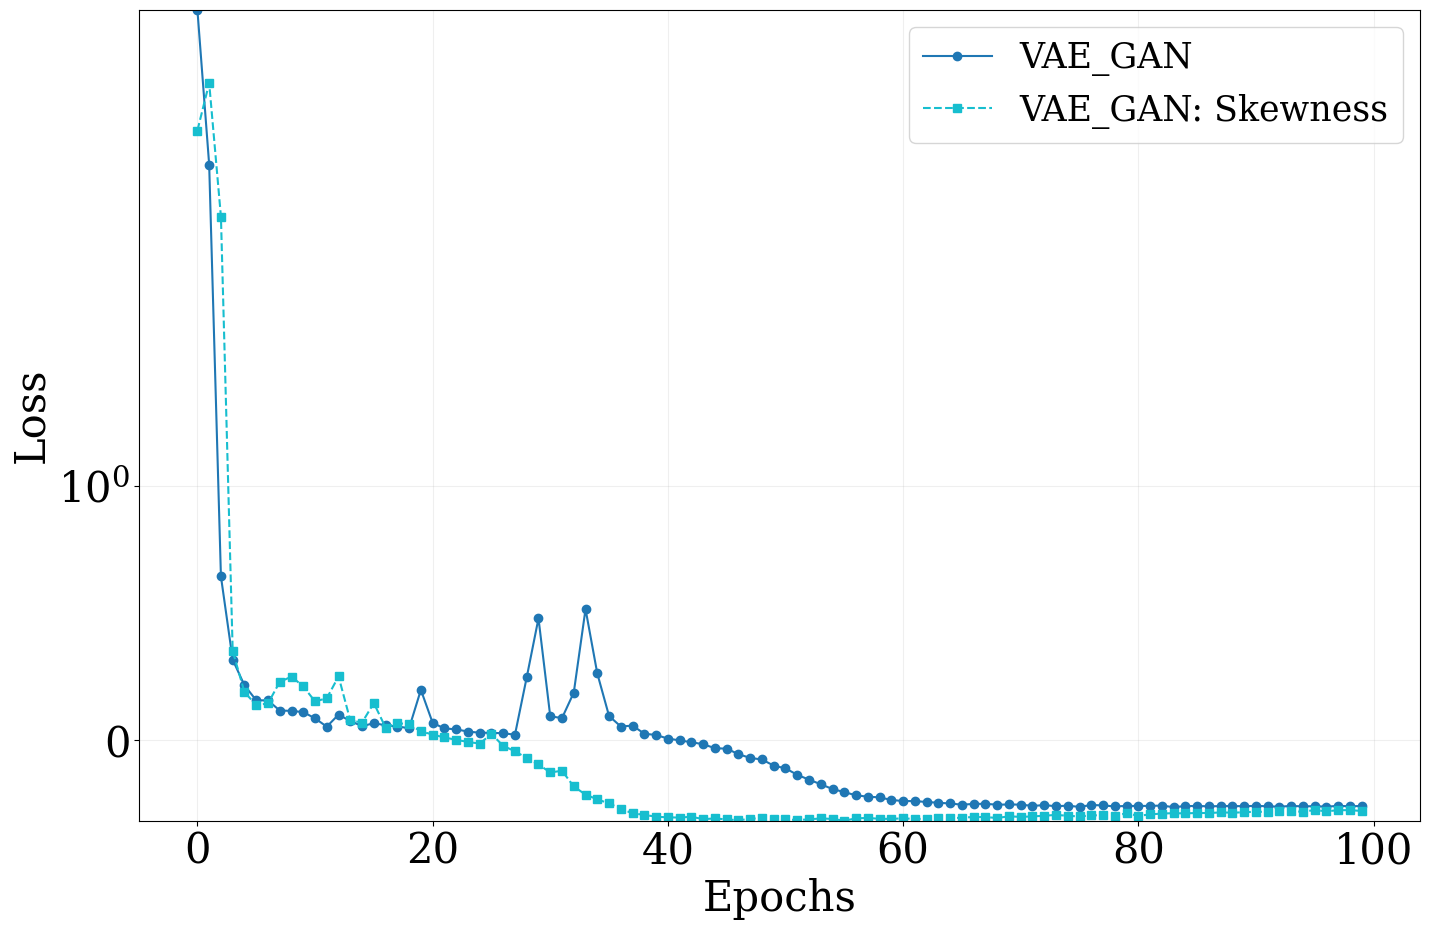

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the 6 .npy files
loss_files = [
    # "/content/loss/channel_est_vae_multi_antenna/losses_d.npy",
    "/content/loss/channel_est_wgan_gp_vae_multi_antenna/losses_d.npy",
    "/content/loss/channel_est_wgan_gp_vae_skew_multi_antenna/losses_d.npy"
]
loss_values = [np.load(f) for f in loss_files]

# breakpoint()
labels = [
    # "VAE",
    "VAE_GAN",
    "VAE_GAN: Skewness"
]
# Assuming each list of loss values is the same length, generate x-axis values (e.g., epochs)
epochs = np.arange(len(loss_values[0]))

# Set up the plot style and formatting
plt.figure(figsize=(15, 10))

plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 30
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams["legend.fontsize"] = 25

# Define line styles and colors
line_styles = ["-o", "--s", "-x"]
colors = plt.cm.tab10(np.linspace(0, 1, len(loss_files)))

# Plot each set of loss values with different styles and colors
for i, (loss, line_style, color, label) in enumerate(
    zip(loss_values, line_styles, colors, labels)
):
    plt.plot(epochs, loss, line_style, label=label, color=color)

# Set plot labels and grid
plt.xlabel("Epochs")
plt.ylabel("Loss")
# plt.xticks(np.arange(0, 11), np.arange(0, 501))
plt.legend(loc="upper right")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.ylim(np.min(np.stack(loss_values)), np.max(np.stack(loss_values)))
plt.yscale("symlog")

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig("WGAN_C_Loss.png", format="png", dpi=100, bbox_inches="tight")
plt.show()


<Figure size 2000x1000 with 0 Axes>

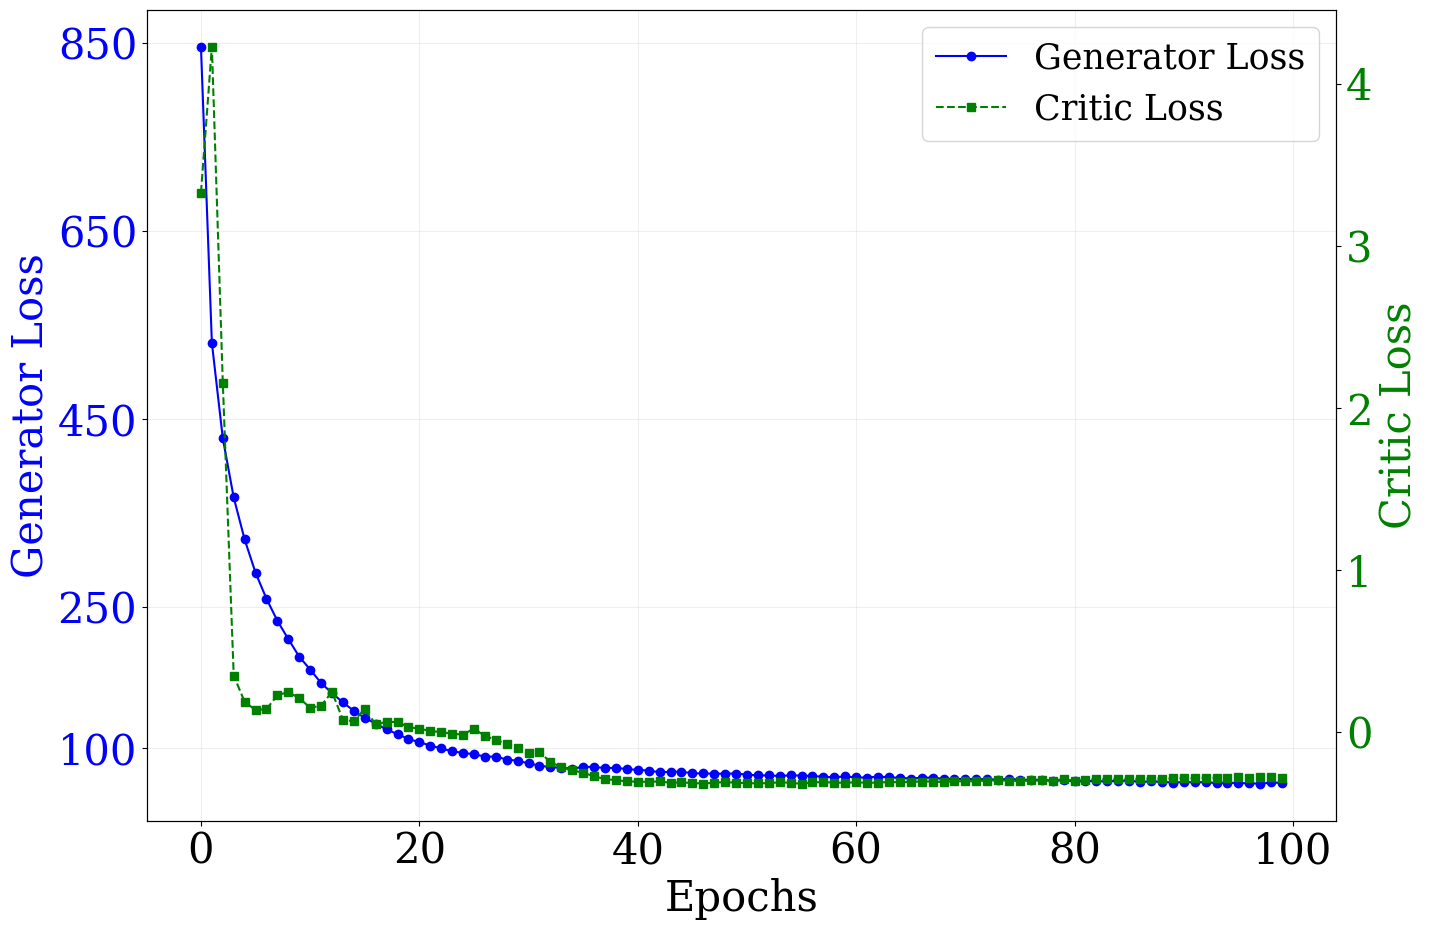

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Load the files
loss_files = [
    "/content/loss/channel_est_wgan_gp_vae_skew_multi_antenna/losses_g.npy",
    "/content/loss/channel_est_wgan_gp_vae_skew_multi_antenna/losses_d.npy"
]
loss_values = [np.load(f) for f in loss_files]

labels = ["Generator Loss", "Critic Loss"]
epochs = np.arange(len(loss_values[0]))

# Create figure
plt.figure(figsize=(20, 10))

# Style settings
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 30
plt.rcParams["axes.labelsize"] = 30
plt.rcParams["axes.titlesize"] = 30
plt.rcParams["xtick.labelsize"] = 30
plt.rcParams["ytick.labelsize"] = 30
plt.rcParams["legend.fontsize"] = 25

# Create two y-axes
fig, ax1 = plt.subplots(figsize=(15, 10))
ax2 = ax1.twinx()

# Plot Generator Loss on left y-axis
line1 = ax1.plot(epochs, loss_values[0], '-o', label="Generator Loss", color='blue')
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Generator Loss", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Plot Critic Loss on right y-axis
line2 = ax2.plot(epochs, loss_values[1], '--s', label="Critic Loss", color='green')
ax2.set_ylabel("Critic Loss", color='green')
ax2.tick_params(axis='y', labelcolor='green')

y2_ticks = np.linspace(0, 4, 5)  # [0, 1, 2, 3, 4]
y1_ticks = [100, 250, 450, 650, 850]

ax1.set_yticks(y1_ticks)
ax2.set_yticks(y2_ticks)

# Add grid
ax1.grid(True, which="both", ls="-", alpha=0.2)

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc="upper right")

# Adjust layout and save
plt.tight_layout()
plt.savefig("fig_loss.png", format="png", dpi=100, bbox_inches="tight")
plt.show()